In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
def read_benches(path):
    with open(path, 'r') as f:
        res_text = f.read()
    return res_text.split('###')[1:]

In [9]:
def boxplot(arrs, bench_title, var_titles, xlabel="variant"):
    fig = plt.figure(figsize =(14, 7))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot(arrs)
    fig.suptitle(bench_title, fontsize=14, fontweight='bold')
    ax.set_ylabel('time in microsecends')
    ax.set_xlabel(xlabel)
    ax.set_xticklabels( var_titles, fontsize=8)

    # show plot
    plt.show()


In [4]:
def barchart(means, title):
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 7))
    labels = ["w/o other binaryen passes", "w/ other binaryen passes"]
    x = np.arange(len(labels))  # the label locations
    rects1 = ax.bar(x - (1.5 * width), [means[0], means[3]], width, label='No Phi')
    rects2 = ax.bar(x, [means[1], means[4]], width, label='Phi')
    rects3 = ax.bar(x + (1.5*width), [means[2], means[5]], width, label='Phi with call')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean Execution Time in Microseconds')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    locations = np.sort(np.concatenate([x - (1.5*width), x, x+(1.5*width)]))
    for i, v in enumerate(means):
        ax.text(locations[i] -(.3 * width), v *0.9, str(v), color='white', fontweight='bold')

    fig.tight_layout()

    plt.show()

In [5]:
def analyse_benchmark(txt):
    lines = txt.splitlines()
    bench_title = lines[0].rsplit('/', 1)[-1]
    variants = txt.split('~~~')[1:]
    titles = [variant.splitlines(1)[0][:-3] for variant in variants]
    arrs = [np.array([int(x) for x in variant.splitlines() if x.isnumeric()]) for variant in variants]
    assert len(arrs) == 6
    means = [a.mean() for a in arrs]
    boxplot(arrs, bench_title, titles)
    barchart(means, bench_title)
    
    print(f"Phi introduced a slow-down of {(means[1]-means[0])*100/means[0]:.1f}% in average.\n\n")
    
    

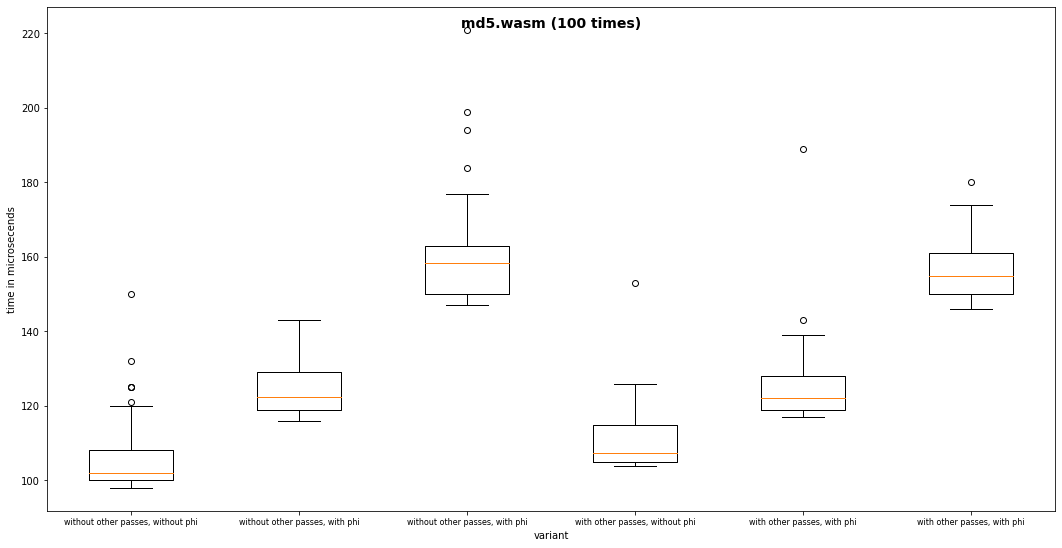

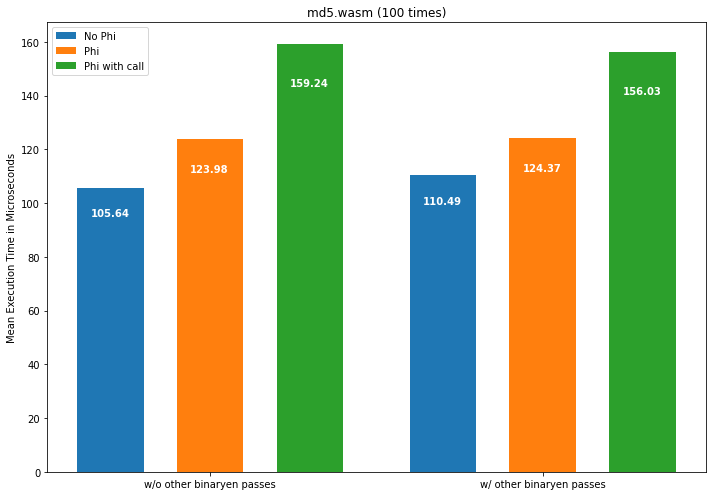

Phi introduced a slow-down of 17.4% in average.




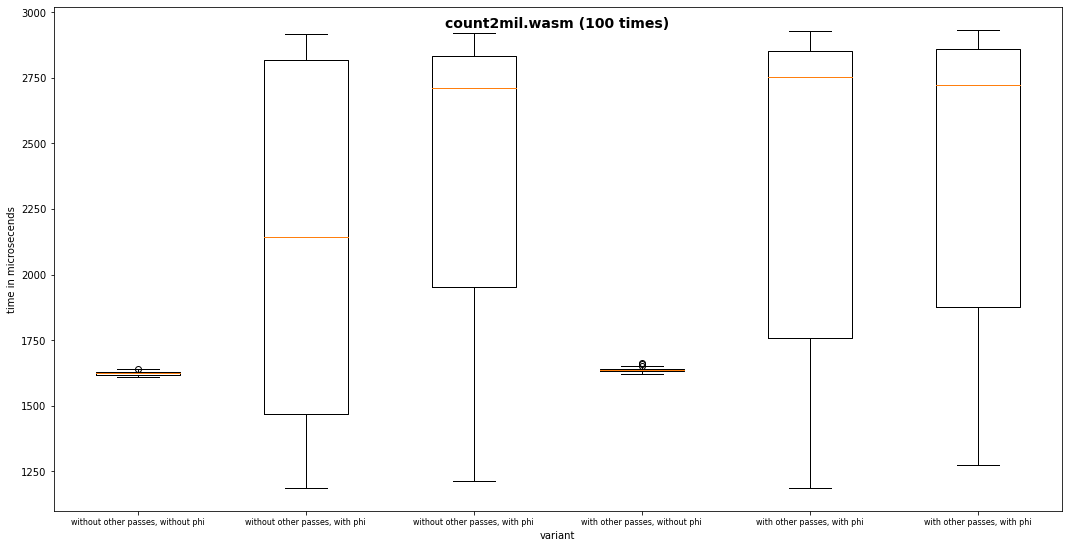

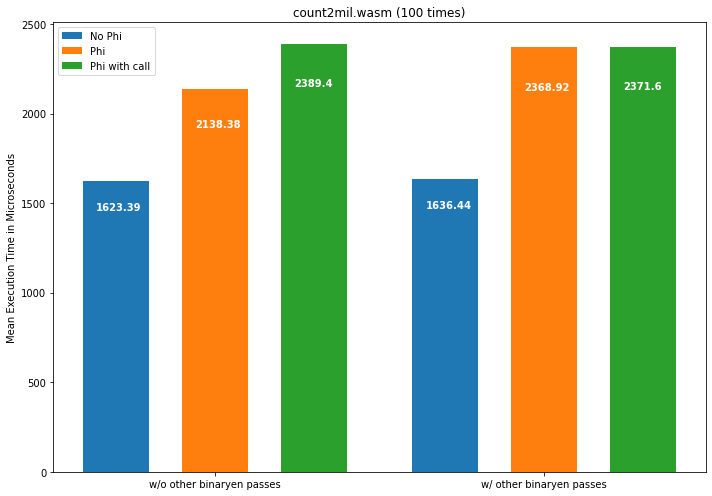

Phi introduced a slow-down of 31.7% in average.




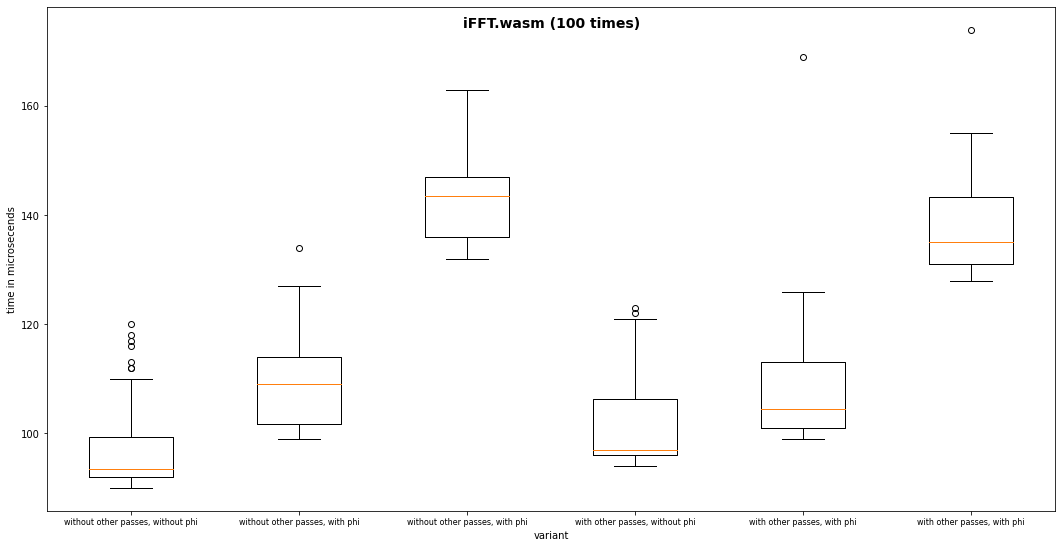

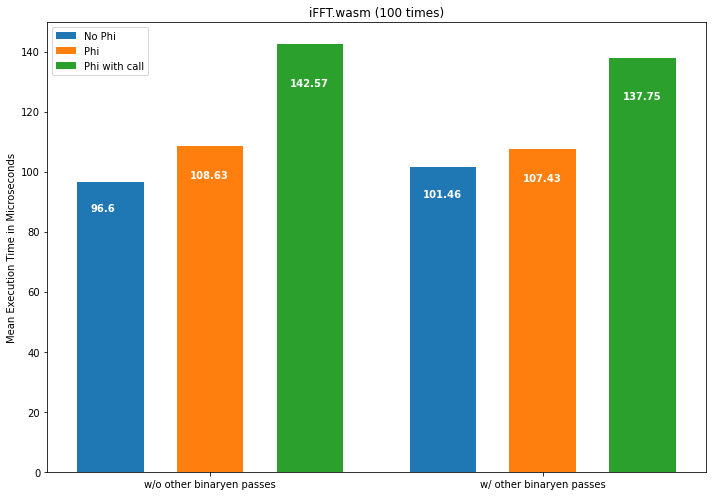

Phi introduced a slow-down of 12.5% in average.




In [10]:
benches = read_benches('../cmake-build-release/benchmarks/res22-03.txt')
for bench in benches:
    analyse_benchmark(bench)

In [ ]:
# TODO: Graph with multiple interval values. 

# - WASMER.

# X axis: frequency (interval)
# Y axis: runtime

# Global atomic variable.
# Global threadlocal bool variable.

# Write in thesis: host-call overhead is vernachl. 



# Schreiben

# Abstract 1 - page max.
# Introduction. (Motivation, Database, WASM)
# Chapter: WASM, runtimes, binaryen (Was schon existiert).
# Chapter: Phi/Implementation (With snippets from injected code).
# Chapter: Evaluation (Benchmarks).
# Chapter: related work. (WASM Paper (and its citations), don't citate runtimes and projects, only academic work.)
# Conclusion.



# Template - Auf Github.















In [102]:
def read_interval_benches(path):
    with open(path, 'r') as f:
        res_text = f.read()
    return res_text.split('%%%')[1:]


def get_call_nums(lines):
    seen = set()
    seen_add = seen.add
    return [int(re.findall("\d+", line)[0]) for line in lines if line.endswith("times!") and not (line in seen or seen_add(line))]

def line_chart(title, means, costs, freqs, xlabel, xlabels):
    fig, ax = plt.subplots(figsize=(16, 7))
    ax.plot(means, label="Mean Total Execution Time")
    ax.plot(costs, label="Mean Execution Time of Single Call to Host")
    ax.set_xticks(range(len(means)))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Mean Execution Time in Microseconds')
    ax.set_title(title)
    plt.xticks(rotation=45)
    ax.legend()
    plt.show()

def analyse_intervals_benchmark(txt):
    lines = txt.splitlines()
    get_call_nums(lines)
    bench_title = lines[0].rsplit('/', 1)[-1]
    variants = txt.split('~~~')[1:]
    arrs = [np.array([int(x) for x in variant.splitlines() if x.isnumeric()]) for variant in variants]
    arrs[0] = np.delete(arrs[0], 0) # discard first measurement, as it includes some start-up slowdown.
    means = [a.mean() for a in arrs]
    stds = [a.std() for a in arrs]
    avg_costs = [0]
    freqs = [0]
    percents = [0]
    call_nums = get_call_nums(lines)
    for mean, calls_num in zip(means[1:], call_nums[1:]):
        avg_costs.append((mean - means[0])/calls_num)
        percents.append((mean - means[0])*100/mean)
        freqs.append(1000000 // (mean/calls_num))
    titles = [f"{2}^{i-1}\n({f:.2e})" for i, f in enumerate(freqs)]
    titles[0] = '0'
    xtitle = "Total Number of Calls to Host during Execution (In Paratheses: Number of Calls per Second)"
    boxplot(arrs, bench_title, titles, xtitle)
    line_chart(bench_title, means, avg_costs, freqs, "Total Number of Calls to Host during Execution (In Paratheses: Number of Calls per Second)", titles)
    if (all([abs(cost) < std for cost, std in zip(avg_costs, stds)])):
        print("In all levels, the mean cost of a call tho the host was smaller than the standard deviation of that level's measurements.")
    print("The estimated host call time as percent of whole execution time:")
    for freq, per in zip(freqs, percents):
        print(f"{int(freq)} Hz: {per:.2f}%", end=", ")
    print()


def analyse_intervals(filename):
    interval_benches = read_interval_benches(filename)
    for bench in interval_benches:
        analyse_intervals_benchmark(bench)



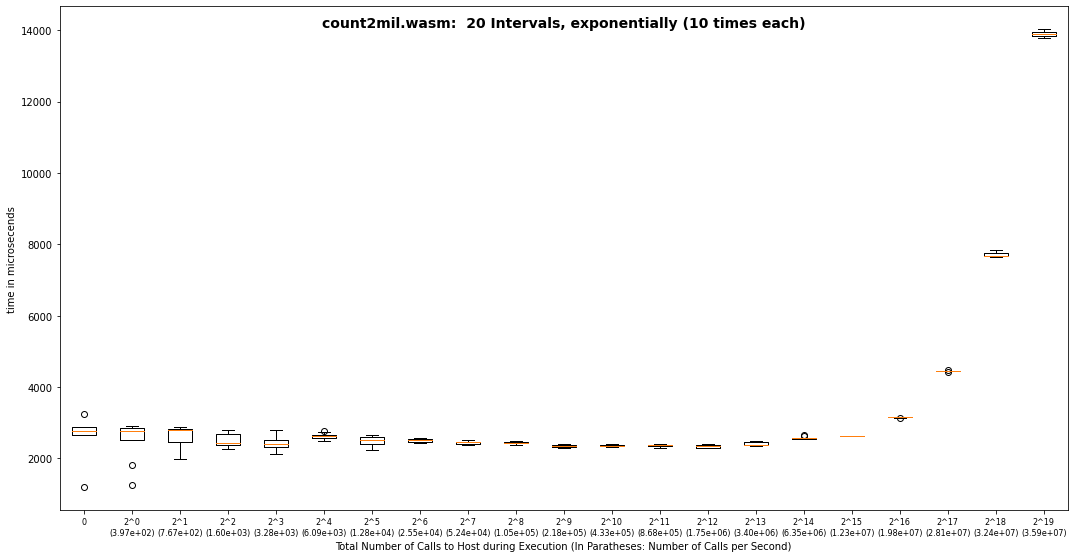

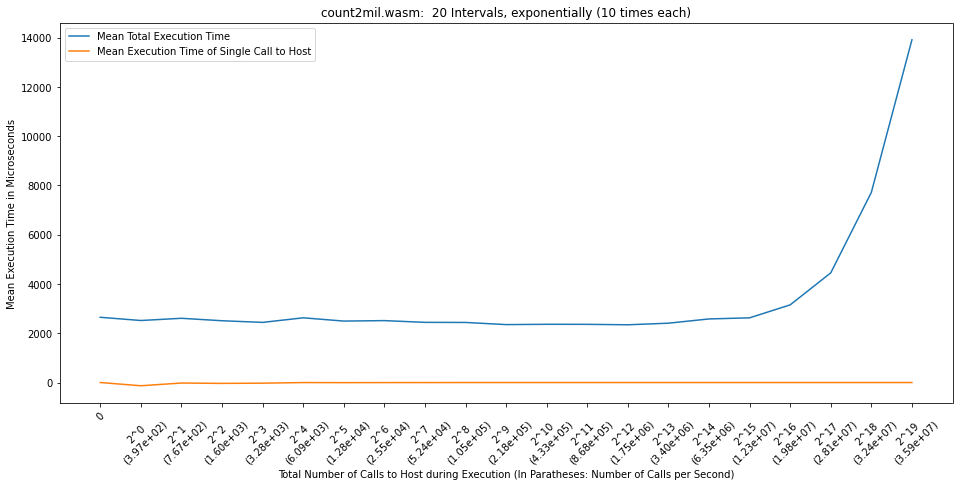

In all levels, the mean cost of a call tho the host was smaller than the standard deviation of that level's measurements.
The estimated host call time as percent of whole execution time:
0 Hz: 0.00%, 397 Hz: -5.20%, 767 Hz: -1.56%, 1595 Hz: -5.59%, 3278 Hz: -8.49%, 6092 Hz: -0.81%, 12831 Hz: -6.17%, 25471 Hz: -5.38%, 52407 Hz: -8.40%, 105008 Hz: -8.60%, 217779 Hz: -12.62%, 433347 Hz: -12.05%, 867558 Hz: -12.10%, 1748666 Hz: -12.98%, 3403371 Hz: -9.94%, 6352152 Hz: -2.59%, 12287825 Hz: -0.86%, 19831196 Hz: 15.99%, 28082945 Hz: 40.52%, 32401047 Hz: 65.69%, 35948981 Hz: 80.96%, 


In [103]:
analyse_intervals('../cmake-build-release/benchmarks/intervals.txt')